# Introduction to Artificial Neural Networks with Keras

_This notebook is based on https://github.com/ageron/handson-ml2, which contains the example code of the second edition of Aurelien Geron's O'Reilly book Hands-on Machine Learning with Scikit-Learn, Keras and TensorFlow (forthcoming)_

I used parts of chapters 10 (Keras nets intro) and 14 (Convolutional networks). 

The original codes:

https://github.com/ageron/handson-ml2/blob/master/10_neural_nets_with_keras.ipynb

https://github.com/ageron/handson-ml2/blob/master/14_convolutional_neural_networks.ipynb

# Setup

_I ran this notebook on a Google Cloud Deep Learning VM, with 2 vCPUs, 13 GB memory and a NVIDIA Tesla K80 GPU. See setup instructions here: https://github.com/cs231n/gcloud_

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead). We use TensorFlow 2.0-preview.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# TensorFlow ≥2.0-preview is required
import tensorflow as tf
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ann"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Building an Image Classifier

First let's import TensorFlow and Keras.

In [2]:
import tensorflow as tf
from tensorflow import keras

In [4]:
tf.__version__

'2.0.0-alpha0'

In [5]:
keras.__version__

'2.2.4-tf'

# Fashion MNIST dataset

Let's start by loading the fashion MNIST dataset. Keras has a number of functions to load popular datasets in `keras.datasets`. The dataset is already split for you between a training set and a test set, but it can be useful to split the training set further to have a validation set:

In [6]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


The training set contains 60,000 grayscale images, each 28x28 pixels:

In [7]:
X_train_full.shape

(60000, 28, 28)

In [8]:
X_train_full[0,]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,
          0,   0,  13,  73,   0,   0,   1,   4,   0,   0,   0,   0,   1,
          1,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
          0,  36, 136, 127,  62,  54,   0,   0,   0,   1,   3,   4,   0,
          0,   3],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   6,
          0, 102, 204, 176, 134, 144, 123,  23,   0,   0,   0,   0,  12,
         10,   0],
       [  

Each pixel intensity is represented as a byte (0 to 255):

In [9]:
X_train_full.dtype

dtype('uint8')

# Train-validation split

Let's split the full training set into a validation set and a (smaller) training set. We also scale the pixel intensities down to the 0-1 range and convert them to floats, by dividing by 255.

In [10]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

You can plot an image using Matplotlib's `imshow()` function, with a `'binary'`
 color map:

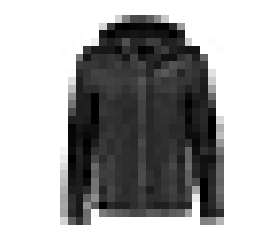

In [11]:
plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

The labels are the class IDs (represented as uint8), from 0 to 9:

In [12]:
y_train

array([4, 0, 7, ..., 3, 0, 5], dtype=uint8)

Here are the corresponding class names:

In [13]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

So the first image in the training set is a coat:

In [14]:
class_names[y_train[0]]

'Coat'

The validation set contains 5,000 images, and the test set contains 10,000 images:

In [15]:
X_valid.shape

(5000, 28, 28)

In [16]:
X_test.shape

(10000, 28, 28)

Let's take a look at a sample of the images in the dataset:

Saving figure fashion_mnist_diagram


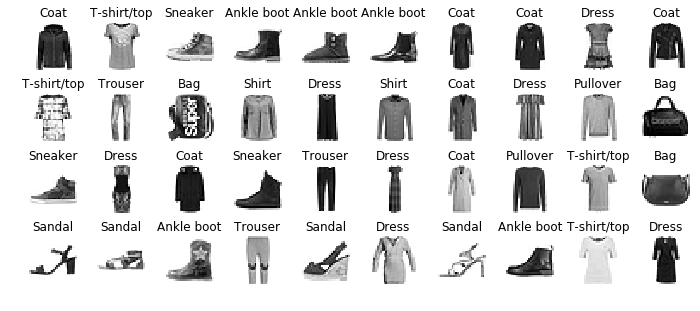

In [17]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig('fashion_mnist_diagram', tight_layout=False)
plt.show()

# Simple fully connected network

In [18]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [20]:
np.random.seed(42)
#tf.set_random_seed(42)   # tf 1.13
tf.random.set_seed(42)    #- tf 2.0

In [21]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu", name='my_first_layer'),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [22]:
model.layers

In [23]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
my_first_layer (Dense)       (None, 300)               235500    
_________________________________________________________________
dense_3 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


In [24]:
hidden1 = model.layers[1]
hidden1.name

'my_first_layer'

In [25]:
model.get_layer(hidden1.name).name

'my_first_layer'

In [26]:
weights, biases = hidden1.get_weights()

In [27]:
weights

array([[ 0.02448617, -0.00877795, -0.02189048, ..., -0.02766046,
         0.03859074, -0.06889391],
       [ 0.00476504, -0.03105379, -0.0586676 , ...,  0.00602964,
        -0.02763776, -0.04165364],
       [-0.06189284, -0.06901957,  0.07102345, ..., -0.04238207,
         0.07121518, -0.07331658],
       ...,
       [-0.03048757,  0.02155137, -0.05400612, ..., -0.00113463,
         0.00228987,  0.05581069],
       [ 0.07061854, -0.06960931,  0.07038955, ..., -0.00384101,
         0.00034875,  0.02878492],
       [-0.06022581,  0.01577859, -0.02585464, ..., -0.00527829,
         0.00272203, -0.06793761]], dtype=float32)

In [28]:
weights.shape

(784, 300)

In [29]:
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [30]:
biases.shape

(300,)

In [31]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

This is equivalent to:

In [32]:
model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.SGD(),
              metrics=[keras.metrics.sparse_categorical_accuracy])

# Training

In [33]:
history = model.fit(X_train, y_train, epochs=50,
                    validation_data=(X_valid, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/50
55000/55000 [==============================] - 7s 126us/sample - loss: 1.4948 - sparse_categorical_accuracy: 0.5757 - val_loss: 1.0042 - val_sparse_categorical_accuracy: 0.7166
Epoch 2/50
55000/55000 [==============================] - 6s 106us/sample - loss: 0.8690 - sparse_categorical_accuracy: 0.7318 - val_loss: 0.7549 - val_sparse_categorical_accuracy: 0.7616
Epoch 3/50
55000/55000 [==============================] - 6s 107us/sample - loss: 0.7176 - sparse_categorical_accuracy: 0.7667 - val_loss: 0.6611 - val_sparse_categorical_accuracy: 0.7890
Epoch 4/50
55000/55000 [==============================] - 6s 107us/sample - loss: 0.6459 - sparse_categorical_accuracy: 0.7891 - val_loss: 0.6049 - val_sparse_categorical_accuracy: 0.8094
Epoch 5/50
55000/55000 [==============================] - 6s 107us/sample - loss: 0.5995 - sparse_categorical_accuracy: 0.8039 - val_loss: 0.5691 - val_sparse_categorical_accuracy: 0.8186
Epoch 6/50


In [34]:
history.params

{'batch_size': 32,
 'epochs': 50,
 'steps': None,
 'samples': 55000,
 'verbose': 0,
 'do_validation': True,
 'metrics': ['loss',
  'sparse_categorical_accuracy',
  'val_loss',
  'val_sparse_categorical_accuracy']}

In [35]:
print(history.epoch)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]


In [36]:
history.history.keys()

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])

Saving figure keras_learning_curves_graph


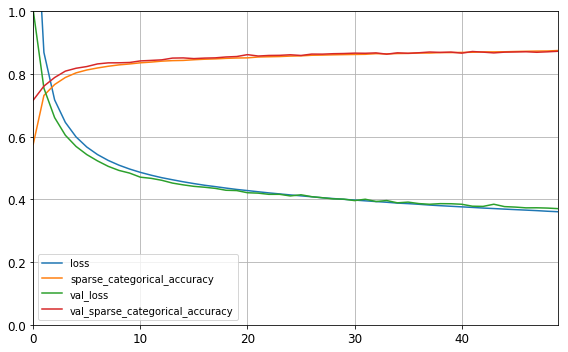

In [37]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
save_fig("keras_learning_curves_graph")
plt.show()

# Evaluation and prediction

In [38]:
model.evaluate(X_test, y_test)

10000/10000 [==============================] - 1s 74us/sample - loss: 0.4073 - sparse_categorical_accuracy: 0.8539


[0.4073339592218399, 0.8539]

In [39]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.09, 0.  , 0.12, 0.  , 0.79],
       [0.  , 0.  , 0.94, 0.  , 0.02, 0.  , 0.04, 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

In [40]:
y_pred = model.predict_classes(X_new)
y_pred

array([9, 2, 1])

In [41]:
np.array(class_names)[y_pred]

array(['Ankle boot', 'Pullover', 'Trouser'], dtype='<U11')

In [42]:
y_new = y_test[:3]
y_new

array([9, 2, 1], dtype=uint8)

# Regression MLP

Let's load, split and scale the California housing dataset (the original one, not the modified one as in chapter 2):

In [43]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()

X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

I0414 05:35:04.713600 139626834154880 california_housing.py:114] Downloading Cal. housing from https://ndownloader.figshare.com/files/5976036 to /home/varghaps/scikit_learn_data


In [44]:
np.random.seed(42)
tf.random.set_seed(42)

In [45]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1)
])
model.compile(loss="mean_squared_error", optimizer="sgd")
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)
X_new = X_test[:3]
y_pred = model.predict(X_new)

Train on 11610 samples, validate on 3870 samples
Epoch 1/20
11610/11610 [==============================] - 1s 113us/sample - loss: 1.6343 - val_loss: 0.9361
Epoch 2/20
11610/11610 [==============================] - 1s 97us/sample - loss: 0.7053 - val_loss: 0.6556
Epoch 3/20
11610/11610 [==============================] - 1s 104us/sample - loss: 0.6343 - val_loss: 0.6028
Epoch 4/20
11610/11610 [==============================] - 1s 107us/sample - loss: 0.5974 - val_loss: 0.5631
Epoch 5/20
11610/11610 [==============================] - 1s 107us/sample - loss: 0.5701 - val_loss: 0.5375
Epoch 6/20
11610/11610 [==============================] - 1s 104us/sample - loss: 0.5474 - val_loss: 0.5165
Epoch 7/20
11610/11610 [==============================] - 1s 106us/sample - loss: 0.5283 - val_loss: 0.5072
Epoch 8/20
11610/11610 [==============================] - 1s 105us/sample - loss: 0.5130 - val_loss: 0.4806
Epoch 9/20
11610/11610 [==============================] - 1s 103us/sample - loss: 0.4989

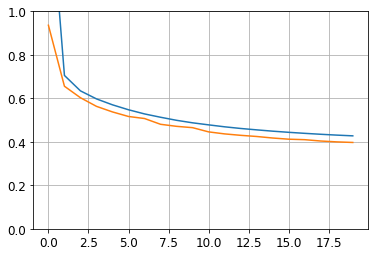

In [46]:
plt.plot(pd.DataFrame(history.history))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [47]:
y_pred

array([[0.38745373],
       [1.6820505 ],
       [3.0960474 ]], dtype=float32)

# Saving and Restoring

In [48]:
model.save("my_keras_model.h5")

In [49]:
model = keras.models.load_model("my_keras_model.h5")

In [50]:
model.predict(X_new)

array([[0.38745373],
       [1.6820505 ],
       [3.0960474 ]], dtype=float32)

In [51]:
model.save_weights("my_keras_weights.ckpt")

In [52]:
model.load_weights("my_keras_weights.ckpt")

# Tackling Fashion MNIST With a CNN

In [53]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [54]:
X_train.shape

(55000, 28, 28, 1)

In [55]:
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3, activation='relu', padding="SAME")

model = keras.models.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=10, activation='softmax'),
])

In [56]:
np.random.seed(42)
tf.random.set_seed(42)

In [57]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=15, validation_data=[X_valid, y_valid])
score = model.evaluate(X_test, y_test)
X_new = X_test[:10] # pretend we have new images
y_pred = model.predict(X_new)

Train on 55000 samples, validate on 5000 samples
Epoch 1/15
55000/55000 [==============================] - 47s 863us/sample - loss: 0.7219 - accuracy: 0.7477 - val_loss: 0.3859 - val_accuracy: 0.8632
Epoch 2/15
55000/55000 [==============================] - 41s 743us/sample - loss: 0.4232 - accuracy: 0.8555 - val_loss: 0.3298 - val_accuracy: 0.8788
Epoch 3/15
55000/55000 [==============================] - 41s 738us/sample - loss: 0.3623 - accuracy: 0.8773 - val_loss: 0.2887 - val_accuracy: 0.8980
Epoch 4/15
55000/55000 [==============================] - 40s 736us/sample - loss: 0.3302 - accuracy: 0.8901 - val_loss: 0.2814 - val_accuracy: 0.8966
Epoch 5/15
55000/55000 [==============================] - 41s 737us/sample - loss: 0.3069 - accuracy: 0.8951 - val_loss: 0.2880 - val_accuracy: 0.8980
Epoch 6/15
55000/55000 [==============================] - 41s 737us/sample - loss: 0.2915 - accuracy: 0.8993 - val_loss: 0.2778 - val_accuracy: 0.9020
Epoch 7/15
55000/55000 [=====================

In [58]:
score

[0.32131441072821615, 0.9055]

Saving figure keras_learning_curves_graph


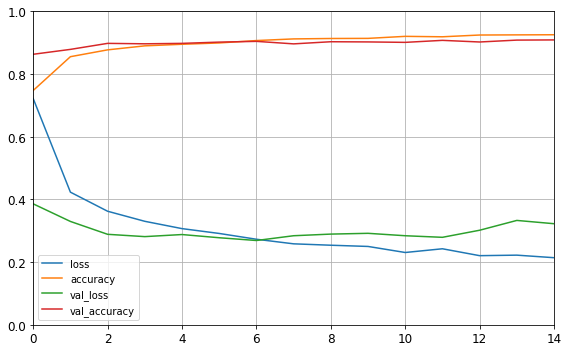

In [59]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
save_fig("keras_learning_curves_graph")
plt.show()